In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import dill
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import lovely_tensors as lt
lt.monkey_patch()

from csng.utils.mix import seed_all
from csng.utils.data import crop, Normalize, PerSampleStoredDataset, MixedBatchLoader
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders
from csng.brainreader_mouse.encoder import get_encoder
from csng.mouse_v1.data import get_mouse_v1_dataloaders
from csng.data import get_syn_dataloaders

DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

In [7]:
### config setup
cfg = {
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
    },
    "device": os.environ["DEVICE"],
    "seed": 0,
}
print(f"... Running on {cfg['device']} ...")
seed_all(cfg["seed"])

... Running on cuda:0 ...


## Load encoder

In [10]:
encoder = get_encoder(
    ckpt_path=os.path.join(DATA_PATH, "models", "encoder_b6.pth"),
    device=os.environ["DEVICE"],
    eval_mode=True,
)

[INFO] Loading encoder checkpoint from /media/jan/ext_ssd/csng_data/models/encoder_b6.pth


## Create synthetic data
Get images from the SENSORIUM 2022 mouse V1 data, crop 256x144 into different patches, and feed them into the encoder to get the synthetic data (pairs of patches and predicted responses).

### Get base dataloader

#### Mouse V1

In [ ]:
### mouse v1 data
cfg["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "scale": 1., # keep 256x144
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 1,
        "seed": cfg["seed"],
        "use_cache": False,
    },
    "crop_win": (22, 36),
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": cfg["device"],
}

In [ ]:
base_dls, neuron_coords = get_mouse_v1_dataloaders(config=cfg)
base_dls = base_dls["mouse_v1"]

In [ ]:
### show data
sample_data_key = base_dls["train"].data_keys[0]
datapoint = next(iter(base_dls["train"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in base_dls['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in base_dls['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in base_dls['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in base_dls['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), cfg["data"]["mouse_v1"]["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

#### Brainreader mouse V1

In [11]:
### brainreader mouse data config
cfg["data"]["brainreader_mouse"] = {
    "device": cfg["device"],
    "mixing_strategy": cfg["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 1,
    "sessions": list(range(1, 23)),
    "resize_stim_to": None, # keep original size 144x256
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}
base_dls = get_brainreader_mouse_dataloaders(cfg["data"]["brainreader_mouse"])["brainreader_mouse"]

Training dataset:	 99000 samples
Validation dataset:	 11000 samples
Test dataset:		 1050 samples

stimuli:
  torch.Size([1, 1, 144, 256])
  min=-2.015  max=2.827
  mean=-0.717  std=1.046
responses:
  torch.Size([1, 9395])
  min=-0.000  max=25.292
  mean=0.445  std=1.355


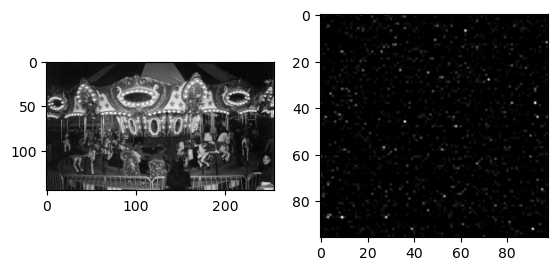

In [12]:
### show data
sample_data_key = "1"
tier = "train"
sample_idx = 0

datapoint = next(iter(base_dls[tier].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in base_dls['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in base_dls['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in base_dls['test'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

### Run through encoder

In [13]:
class SyntheticDatasetGenerator(Dataset):
    """Extracts patches from given images and encodes them with a pretrained encoder ("on the fly")."""

    def __init__(
        self,
        encoder,
        base_dl,
        data_key,
        patch_shape,
        overlap=(0, 0),
        stim_transform=None,
        resp_transform=None,
        device="cpu",
    ):
        assert base_dl.batch_size == 1, "Batch size must be 1."
        assert len(overlap) == 2, "Overlap must be a tuple of 2 elements."
        
        self.base_dl = base_dl
        self.base_dl_iter = iter(base_dl)
        self.data_key = data_key
        self.patch_shape = patch_shape
        self.overlap = overlap
        self.stim_transform = stim_transform
        self.resp_transform = resp_transform
        self.device = device

        self.encoder = encoder
        self.encoder.eval()

        self.seen_idxs = set()

    def __len__(self):
        return len(self.base_dl)

    def __getitem__(self, idx):
        if idx in self.seen_idxs:
            raise ValueError(f"Index {idx} already seen.")
        self.seen_idxs.add(idx)

        sample = next(self.base_dl_iter)
        img, pupil_center = sample.images.to(self.device), None
        if hasattr(sample, "pupil_center"):
            pupil_center = sample.pupil_center.to(self.device)

        patches, syn_resps = self.extract_patches(img=img, pupil_center=pupil_center)
        if pupil_center is not None:
            return patches, syn_resps, pupil_center.repeat(patches.shape[0], 1)
        return patches, syn_resps

    @torch.no_grad()
    def extract_patches(self, img, pupil_center=None):
        h, w = img.shape[-2:]
        patches = []
        patch_shape = self.patch_shape

        for y in range(0, h - patch_shape[0] + 1, patch_shape[0] - self.overlap[0]):
            for x in range(0, w - patch_shape[1] + 1, patch_shape[1] - self.overlap[1]):
                # patch = img[:, y:y+patch_size, x:x+patch_size]
                patch = img[..., y:y+patch_shape[0], x:x+patch_shape[1]]
                patches.append(patch)

        ### merge into a batch
        patches = torch.cat(patches, dim=0).to(self.device)
        assert patches.shape[-2:] == self.patch_shape, f"Expected patch shape {self.patch_shape}, got {patches.shape[-2:]}."

        ### encode patches = get resps
        # if self.expand_stim_for_encoder:
        #     patches_for_encoder = F.interpolate(patches, size=self.patch_size, mode="bilinear", align_corners=False)
        #     ### take only the center of the patch - the encoder's resps cover only the center part
        #     patches = patches[:, :, int(patch_size / 4):int(patch_size / 4) + self.patch_size,
        #                 int(patch_size / 4):int(patch_size / 4) + self.patch_size]
        # patches = self._scale_for_encoder(patches)
        if self.encoder is not None:
            if hasattr(self.encoder, "shifter") and self.encoder.shifter:
                resps = self.encoder(patches, data_key=self.data_key, pupil_center=pupil_center.expand(patches.shape[0], -1))
            else:
                resps = self.encoder(patches, data_key=self.data_key)

        if self.resp_transform is not None:
            resps = self.resp_transform(resps)

        if self.stim_transform is not None:
            patches = self.stim_transform(patches)

        return patches, resps

In [14]:
class BatchPatchesDataLoader():
    """Dataloader that mixes patches from different images within a batch."""

    def __init__(self, dataloader):
        self.dataloader_iter = iter(dataloader)

    def __len__(self):
        return len(self.dataloader_iter)

    def __iter__(self):
        for batch in self.dataloader_iter:
            patches, resps = batch[:2] # (B, N_patches, C, H, W)
            patches = patches.view(-1, *patches.shape[2:])
            resps = resps.view(-1, *resps.shape[2:])

            ### shuffle patch-resp pairs
            idx = torch.randperm(patches.shape[0])
            patches = patches[idx]
            resps = resps[idx].float()

            if len(batch) == 3:
                pupil_center = batch[2].view(-1, *batch[2].shape[2:])[idx]
                yield patches, resps, pupil_center
            yield patches, resps

In [15]:
### print info
for tier, mixed_dl in base_dls.items():
    print(f"{tier}:")
    print(f"    source data keys:\n     ", '\n      '.join(mixed_dl.data_keys))
    print(f"    size of datasets: {', '.join([str(len(mixed_dl) * _dl.batch_size) for _dl in mixed_dl.dataloaders])}")
print(
    f"\nEncoder was trained on data keys:\n  {' '.join(list(encoder.readout.keys()))}"
)

train:
    source data keys:
      1
      2
      3
      4
      5
      6
      7
      8
      9
      10
      11
      12
      13
      14
      15
      16
      17
      18
      19
      20
      21
      22
    size of datasets: 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000, 99000
test:
    source data keys:
      1
      2
      3
      4
      5
      6
      7
      8
      9
      10
      11
      12
      13
      14
      15
      16
      17
      18
      19
      20
      21
      22
    size of datasets: 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050
val:
    source data keys:
      1
      2
      3
      4
      5
      6
      7
      8
      9
      10
      11
      12
      13
      14
      15
      16
      17
      18
      19
      20
      21
      22
    size of datasets:

In [16]:
### synthetic data config
cfg["syn_data"] = {
    "data_part_src": "train", # from base_dls
    "data_part_target": "train", # to which folder to save the synthetic data
    "data_key_src": "1", # from base_dls
    "max_samples": 1000, # None or int
    "save_stats": True,
    "patch_dataset": {
        "data_key": "6", # data key on which the encoder was trained
        "patch_shape": (36, 64),
        "overlap": (0, 0),
        "stim_transform": None,
        "resp_transform": None,
        "device": cfg["device"],
    },
    "patch_dataloader": {
        "batch_size": 4,
        "shuffle": False,
    },
}
print(
    f"data_part_src:\t\t{cfg['syn_data']['data_part_src']}"
    f"\ndata_part_target:\t{cfg['syn_data']['data_part_target']}"
    f"\ndata_key_src:\t\t{cfg['syn_data']['data_key_src']}"
    f"\nmax_samples:\t\t{cfg['syn_data']['max_samples']}"
    f"\nencoder data key:\t{cfg['syn_data']['patch_dataset']['data_key']}"
)

data_part_src:		train
data_part_target:	train
data_key_src:		1
max_samples:		1000
encoder data key:	6


In [17]:
### setup synthetic data dataset and dataloader
base_dl = base_dls[cfg["syn_data"]["data_part_src"]].dataloaders[
    base_dls[cfg["syn_data"]["data_part_src"]].data_keys.index(cfg["syn_data"]["data_key_src"])
]
patch_dset = SyntheticDatasetGenerator(encoder=encoder, base_dl=base_dl, **cfg["syn_data"]["patch_dataset"])
patch_dl = DataLoader(patch_dset, **cfg["syn_data"]["patch_dataloader"])
dl = BatchPatchesDataLoader(dataloader=patch_dl)

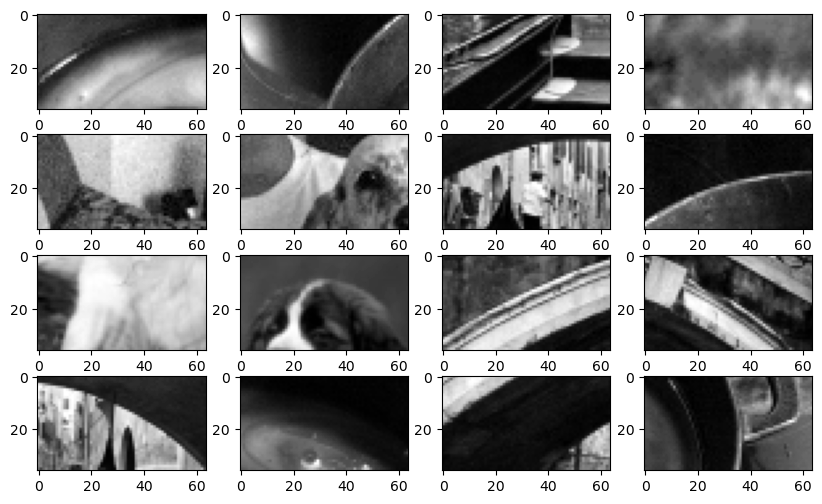

In [12]:
### show data
seed_all(cfg["seed"])
s = next(iter(dl))

fig = plt.figure(figsize=(10, 6))
axes = fig.subplots(4, 4).flatten()
for i in range(16):
    axes[i].imshow(s[0][i].squeeze().cpu(), cmap="gray")
plt.show()

### Save synthetic data

In [18]:
### config where to save the synthetic data
cfg["syn_data"]["path"] = os.path.join(
    DATA_PATH,
    f"synthetic_data_{cfg['syn_data']['data_key_src']}_{cfg['syn_data']['data_part_src']}",
    cfg["syn_data"]["patch_dataset"]["data_key"],
    cfg["syn_data"]["data_part_target"],
)
print(f"{cfg['syn_data']['path']=}")
if os.path.exists(cfg["syn_data"]["path"]):
    print("Directory already exists.")

cfg['syn_data']['path']='/media/jan/ext_ssd/csng_data/synthetic_data_1_train/6/train'


In [19]:
### prepare synthetic data destination
os.makedirs(cfg["syn_data"]["path"], exist_ok=True)
# save config in the parent directory
with open(os.path.join(os.path.dirname(cfg["syn_data"]["path"]), f"config_{cfg['syn_data']['data_part_target']}.json"), "w") as f:
    json.dump(cfg, f)
# save the encoder in the parent directory
torch.save({
    "encoder": encoder.state_dict(),
    "config": cfg,
}, os.path.join(os.path.dirname(cfg["syn_data"]["path"]), f"encoder_{cfg['syn_data']['data_part_target']}.pth"), pickle_module=dill)

In [20]:
### save synthetic data
seed_all(cfg["seed"])
sample_idx = 0
resps_all = [] # for statistics
for b_idx, b in enumerate(dl):
    ### b = (patches, resps, pupil_center) or (patches, resps)
    patches, resps = b[:2]

    if cfg["syn_data"]["save_stats"]:
        resps_all.append(resps.cpu())

    ### save each sample separately
    for i in range(patches.shape[0]):
        sample_path = os.path.join(cfg["syn_data"]["path"], f"{sample_idx}.pickle")
        with open(sample_path, "wb") as f:
            to_save = {
                "stim": patches[i].cpu(),
                "resp": resps[i].cpu(),
            }
            if len(b) == 3: # add pupil_center if present
                to_save["pupil_center"] = b[2][i].cpu()
            pickle.dump(to_save, f)
        sample_idx += 1
        if sample_idx >= cfg["syn_data"]["max_samples"]:
            break
    if sample_idx >= cfg["syn_data"]["max_samples"]:
        break

    if b_idx % 50 == 0:
        print(f"Batch {b_idx} processed ({sample_idx} samples saved).")

Batch 0 processed (64 samples saved).


In [22]:
### save statistics of responses
if cfg["syn_data"]["save_stats"]:
    print(f"[INFO] Saving stats to {os.path.join(cfg['syn_data']['path'], 'stats')}...")
    resps_all = torch.cat(resps_all, dim=0).cpu()
    iqr = torch.quantile(resps_all, 0.75, dim=0) - torch.quantile(resps_all, 0.25, dim=0)
    med = torch.median(resps_all, dim=0).values
    mean = resps_all.mean(dim=0)
    std = resps_all.std(dim=0)
    if not os.path.exists(os.path.join(cfg["syn_data"]["path"], "stats")):
        os.makedirs(os.path.join(cfg["syn_data"]["path"], "stats"))
    else:
        print("[WARNING] stats directory already exists")
    np.save(
        os.path.join(
            cfg["syn_data"]["path"],
            "stats",
            f"responses_iqr.npy"
        ),
        iqr.cpu().numpy(),
    )
    np.save(
        os.path.join(
            cfg["syn_data"]["path"],
            "stats",
            f"responses_mean.npy"
        ),
        mean.cpu().numpy(),
    )
    np.save(
        os.path.join(
            cfg["syn_data"]["path"],
            "stats",
            f"responses_med.npy"
        ),
        med.cpu().numpy(),
    )
    np.save(
        os.path.join(
            cfg["syn_data"]["path"],
            "stats",
            f"responses_std.npy"
        ),
        std.cpu().numpy(),
    )
    print(f"[INFO] Stats saved.")

[INFO] Saving stats to /media/jan/ext_ssd/csng_data/synthetic_data_1_train/6/train/stats...
[INFO] Stats saved.


## Load synthetic data

In [119]:
### config for synthetic data
cfg["data"]["syn_data"] = {
    "data_dicts": [
        {
            "path": os.path.join(DATA_PATH, "synthetic_data_1_train", "6"),
            "data_key": "syn_6",
            "load_neuron_coords": False,
        },
    ],
    "append_data_tiers": ["train"],
    "responses_shift_mean": True,
    "responses_clip_min": 0,
    "responses_clip_max": None,

    "device": cfg["device"],
    "batch_size": 32,
    "shuffle": False,
    "mixing_strategy": cfg["data"]["mixing_strategy"],
    "max_training_batches": None,
    "return_pupil_center": False,
    "return_neuron_coords": False,
}

In [ ]:
### get synthetic dataloaders
syn_dls, neuron_coords = get_syn_dataloaders(config=cfg["data"]["syn_data"])

Training dataset:	 1024 samples
Validation dataset:	 0 samples
Test dataset:		 0 samples

stimuli:
  torch.Size([32, 1, 36, 64])
  min=-2.330  max=2.996
  mean=-0.752  std=1.205
responses:
  torch.Size([32, 8587])
  min=0.000  max=14.288
  mean=0.683  std=0.642


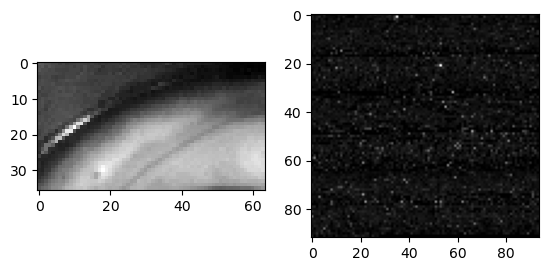

In [125]:
### show data
sample_data_key = "syn_6"
tier = "train"
sample_idx = 0

datapoint = next(iter(syn_dls[tier].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'].dataloaders) if 'train' in dls else '0'} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'].dataloaders) if 'val' in dls else '0'} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'].dataloaders) if 'test' in dls else '0'} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")